In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [ ]:
from util import show, plot_images, plot_tensors

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from skimage.measure import compare_psnr

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size=50
TRAIN_DATA_PATH = "./Confocal_BPAE_B/raw"
GT_DATA_PATH = "./Confocal_BPAE_B/gt"
TRANSFORM_IMG = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()

])
train_data = torchvision.datasets.ImageFolder(
    root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
gt_data = torchvision.datasets.ImageFolder(
    root=GT_DATA_PATH, transform=TRANSFORM_IMG)

dataset1 = train_data
dataset2 = gt_data

In [ ]:
class gtmatch():
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y = self.dataset2[int(index / batch_size % batch_size)][0]
        return x, y

    def __len__(self):
        return len(self.dataset1)


newdataset = gtmatch(dataset1, dataset2, batch_size)

In [ ]:
from models.RIM_v3 import RIM

In [ ]:
model = RIM()

In [ ]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import logging
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [10]:
from torch.utils.data.sampler import SequentialSampler
validation_split = .2
random_seed = 42
shuffle_dataset = False

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_indices, val_indices = indices[split:], indices[:split]

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)


train_loader = torch.utils.data.DataLoader(
    newdataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## RIM

In [11]:
data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_val_loss = 1
st1=0
st2=-0
noise_weight=.5

for i, batch in enumerate(data_loader):

    clean_images, gt = batch
    
    noise=torch.distributions.poisson.Poisson(clean_images.detach()).sample()*noise_weight
    gaussian=torch.randn(clean_images.size())*noise_weight
    noisy_images=clean_images+noise+gaussian
    
    if i==0:
        loglikelihood=torch.zeros(noisy_images.shape)
    
    net_input=torch.cat([noisy_images, loglikelihood],dim=1)

    model.train()

    net_output, st1, st2 = model(net_input, st1, st2, i)
    
    pred_image=net_output*noisy_images
    loglikelihood=(pred_image+noise)-noisy_images
    loss = loss_function(net_output, noisy_images)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    losses.append(loss.item())
    model.eval()

    val_loss = loss_function(net_output, noisy_images)
    val_losses.append(val_loss.item())

    print("Loss (", i, "): \t", round(loss.item(), 4))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        
        net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
        noisy_input.append(net_input_np)

        denoised = noisy_images+model(net_input, st1, st2, i)[0].detach()
        denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        best_images.append(denoised_arr)

        clean_comp = clean_images.detach().cpu().numpy()[
            0, 0].astype(np.float64)
        clean_image_corr.append(clean_images)
        
        best_psnr = compare_psnr(clean_comp, denoised_arr)
        
        print("\tModel PSNR: ", np.round(best_psnr, 2))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss ( 0 ): 	 0.2627


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  8.15
Loss ( 1 ): 	 0.2786
Loss ( 2 ): 	 0.2814
Loss ( 3 ): 	 0.2656
Loss ( 4 ): 	 0.2841
Loss ( 5 ): 	 0.2884
Loss ( 6 ): 	 0.292
Loss ( 7 ): 	 0.2871
Loss ( 8 ): 	 0.2737
Loss ( 9 ): 	 0.2622
	Model PSNR:  8.92
Loss ( 10 ): 	 0.2853
Loss ( 11 ): 	 0.2713
Loss ( 12 ): 	 0.2784
Loss ( 13 ): 	 0.2846
Loss ( 14 ): 	 0.2926
Loss ( 15 ): 	 0.2821


In [12]:
model_output = []
Input_PSNR = []
Model_PSNR = []

model_output = []
Input_PSNR = []
Model_PSNR = []
Model_loss = []
clipped_model_loss = []


for i, batch in enumerate(validation_loader):

    clean_images, gt = batch
    
    noise=torch.distributions.poisson.Poisson(clean_images.detach()).sample()*noise_weight
    gaussian=torch.randn(clean_images.size())*noise_weight
    noisy_images=clean_images+noise+gaussian
        
    net_input=torch.cat([noisy_images, loglikelihood],dim=1)

    model.eval()

    denoised = noisy_images+model(net_input, st1, st2, i)[0].detach()
    denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    model_output.append([torch.from_numpy(clean_comp),torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), gt])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))

    Model_loss.append(loss_function(denoised, noisy_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), noisy_images))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.m

Input PSNR =  5.76
Simple RIM PSNR =  8.3516

Simple RIM Loss =  tensor(0.0045)
Clipped Simple RIM Loss =  tensor(0.3954, dtype=torch.float64)


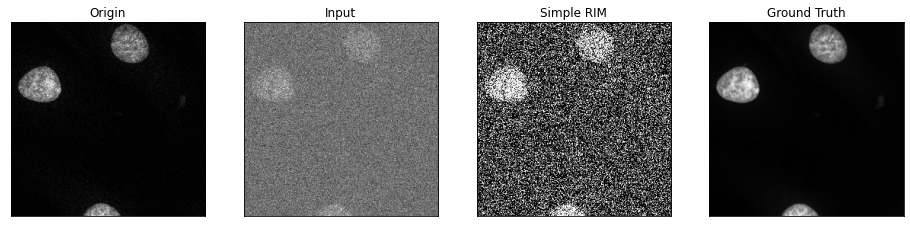

In [13]:
idx=2
plot_tensors(model_output[idx], ["Origin","Input", "Simple RIM","Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))

In [14]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))

Average Input PSNR =  5.83
Average Simple RIM PSNR =  8.1937

Average Simple RIM Loss =  0.0075
Average Clipped Simple RIM Loss =  0.4001


## RIM with J-Invariant Mask

In [ ]:
from mask_RIM_v2 import Masker
masker = Masker(width=4, mode='interpolate')

data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_Jimages = []
best_val_loss = 1
st1=0
st2=0

for i, batch in enumerate(data_loader):
    noisy_images, clean_images, gt = batch

    model.train()

    net_input, mask = masker.mask(noisy_images, i % (masker.n_masks - 1))
    

    net_output, st1, st2 = model(net_input, st1, st2, i)

    loss = loss_function(net_output*mask, noisy_images*mask)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    losses.append(loss.item())

    model.eval()
    val_loss = loss_function(net_output*mask, noisy_images*mask)
    val_losses.append(val_loss.item())

    print("Loss (", i, "): \t", round(loss.item(), 4))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = noisy_images*model(noisy_images, st1, st2, i)[0].detach()
        Jinv = noisy_images * \
            masker.infer_full_image(noisy_images, model, st1, st2, i)[0].detach()
        Jinv = np.clip(-Jinv, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
        denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        clean_comp = clean_images.detach().cpu().numpy()[
            0, 0].astype(np.float64)

        best_psnr = compare_psnr(clean_comp, Jinv)

        noisy_input.append(net_input_np)
        best_images.append(denoised_arr)
        best_Jimages.append(Jinv)
        clean_image_corr.append(clean_images)
        print("\tModel PSNR: ", np.round(best_psnr, 2))

In [ ]:
model_output = []
Input_PSNR = []
Model_PSNR = []
JInv_PSNR = []
Model_loss = []
clipped_model_loss = []

JInv_loss = []
clipped_JInv_loss = []

for i, batch in enumerate(validation_loader):

    noisy_images, clean_images, gt = batch

    model.eval()

    net_input = noisy_images

    denoised = noisy_images*model(noisy_images, st1, st2, i)[0].detach()
    denoised_arr = np.clip(-denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)
    Jinv = noisy_images * \
        masker.infer_full_image(noisy_images, model, st1, st2, i)[0].detach()
    Jinv_np = np.clip(-Jinv, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)

    model_output.append([torch.from_numpy(clean_comp),torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), torch.from_numpy(Jinv_np), gt])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    JInv_PSNR.append(compare_psnr(clean_comp, Jinv_np))
    
    Model_loss.append(loss_function(denoised, noisy_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), noisy_images))
    
    JInv_loss.append(loss_function(Jinv, noisy_images))
    clipped_JInv_loss.append(loss_function(
        torch.from_numpy(Jinv_np), noisy_images))

In [ ]:
idx=2
plot_tensors(model_output[idx], ["Origin","Input", "Simple RIM",
                               "J-Invariant RIM", "Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("J-Invariant RIM PSNR = ", np.round(JInv_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))
print("")
print("J-Invariant RIM Loss = ", np.round(JInv_loss[idx], 4))
print("Clipped J-Invariant RIM Loss = ", np.round(clipped_JInv_loss[idx], 4))

In [ ]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("Average J-Invariant RIM PSNR = ", np.round(np.mean(JInv_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))
print("")
print("Average J-Invariant RIM Loss = ", np.round(np.mean(JInv_loss), 4))
print("Average Clipped J-Invariant RIM Loss = ", np.round(np.mean(clipped_JInv_loss), 4))